In [1]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader2, Dataset

import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.metrics import classification_report , confusion_matrix, accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
from pandas.core.common import flatten
import copy

In [2]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256,width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=64, width=64),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
batch_size = 256

In [4]:
import glob
import random
train_data_path = 'Datasets/Face_emotion/train/' 
test_data_path = 'Datasets/Face_emotion/test/' 
# valid_data_path = 'Datasets/Landscape_Classification/Validation Data/' 

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
train_image_paths = list(flatten(train_image_paths))

random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])


#validation
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 




#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

# print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))
print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths),len(valid_image_paths),len(test_image_paths)))


train_image_path example:  Datasets/Face_emotion/train/fearful/im3546.png
class example:  happy
Train size: 22967
Valid size: 5742
Test size: 7178


In [5]:
valid_image_paths[:10]

['Datasets/Face_emotion/train/fearful/im3353.png',
 'Datasets/Face_emotion/train/fearful/im1996.png',
 'Datasets/Face_emotion/train/angry/im3334.png',
 'Datasets/Face_emotion/train/sad/im3538.png',
 'Datasets/Face_emotion/train/happy/im4800.png',
 'Datasets/Face_emotion/train/angry/im2659.png',
 'Datasets/Face_emotion/train/sad/im2429.png',
 'Datasets/Face_emotion/train/sad/im3367.png',
 'Datasets/Face_emotion/train/sad/im3728.png',
 'Datasets/Face_emotion/train/angry/im1408.png']

In [6]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'happy': 0,
 'sad': 1,
 'fearful': 2,
 'neutral': 3,
 'angry': 4,
 'disgusted': 5,
 'surprised': 6}

In [7]:
class DatasetFetch(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform :
            image = self.transform(image=image)["image"]     
            Trans = torchvision.transforms.Resize((32,32))
            image = Trans(image)
            
        else:   
            image = torch.tensor(image)
            image = image.permute(2,0,1)
            Trans = torchvision.transforms.Resize((32,32))
            image = Trans(image)

        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = DatasetFetch(train_image_paths)
# train_dataset = DatasetFetch(train_image_paths,train_transforms) #test transforms are applied
test_dataset = DatasetFetch(test_image_paths)
valid_dataset = DatasetFetch(valid_image_paths)

torch.Size([3, 32, 32]) 0


['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']

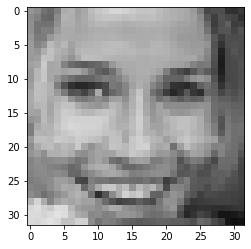

In [8]:
# img = plt.imread('tr.jpeg')
# ar = img.reshape(28,28)
# torch.tensor(img)
x,y = train_dataset[1]
print(x.shape,y)
x= x.permute(1,2,0)

plt.imshow(x)
# train_dataset[0][0].numpy().shape
classes

In [9]:
def plot_loss(loss):
        '''
        Plots the loss curve
        '''
        fig = plt.figure(figsize=(10,10))
        plt.plot(loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show() 

In [10]:
train_loader = DataLoader2(train_dataset,batch_size=batch_size,shuffle=True) 
test_loader = DataLoader2(test_dataset,batch_size=batch_size,shuffle=True) 
valid_loader = DataLoader2(valid_dataset,batch_size=batch_size,shuffle=True) 


In [11]:
def accuracy(train_loader,test_loader,valid_loader=None,model=None,reshape=True):
    train_acc_score, test_acc_score,valid_acc_score = 0.0,0.0,0.0
    model.eval()
    r_pred=[]
    r=[]
    for _,(x,y) in enumerate(train_loader):
        if reshape==True:
            x = x.reshape(x.shape[0],-1)
        scores = model(x)
        _, y_pred = scores.max(1)
        r = r + list(y.numpy())
        r_pred = r_pred + list(y_pred.numpy())
    
    print("\n\n########## Train Data Accuracy ######### \n\n")
    print(classification_report(r,r_pred))
    train_acc_score = accuracy_score(r,r_pred)
    sns.heatmap(confusion_matrix(r,r_pred))
    plt.show()
    
    
    
    r_pred=[]
    r=[]
    for _,(x,y) in enumerate(test_loader):
        if reshape==True:
            x = x.reshape(x.shape[0],-1)
        scores = model(x)
        _, y_pred = scores.max(1)
        r = r + list(y.numpy())
        r_pred = r_pred + list(y_pred.numpy())
    
    print("\n\n########## Test Data Accuracy ######### \n\n") 
    print(classification_report(r,r_pred))
    test_acc_score = accuracy_score(r,r_pred)
    
    sns.heatmap(confusion_matrix(r,r_pred))
    
    if valid_loader is not None:
        r_pred=[]
        r=[]
        for _,(x,y) in enumerate(valid_loader):
            if reshape==True:
                x = x.reshape(x.shape[0],-1)
            scores = model(x)
            _, y_pred = scores.max(1)
            r = r + list(y.numpy())
            r_pred = r_pred + list(y_pred.numpy())
    
        print("\n\n########## Valid Data Accuracy ######### \n\n") 
        print(classification_report(r,r_pred))
        valid_acc_score = accuracy_score(r,r_pred)
        sns.heatmap(confusion_matrix(r,r_pred))
        
    return train_acc_score, test_acc_score,valid_acc_score 


In [12]:
######### CNN Example
class CNN(nn.Module):
    def __init__(self,in_channels=1,num_classes=10):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,16,kernel_size=(2,2),stride=(1,1),padding=(1,1))
        self.conv2 = nn.Conv2d(16,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv3 = nn.Conv2d(16,8,kernel_size=(2,2),stride=(1,1),padding=(1,1))
        self.conv4 = nn.Conv2d(8,8,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.fc1 = nn.Linear(8*8*8,32)        
        self.fc2 = nn.Linear(32,10)        
        self.fc3 = nn.Linear(10,num_classes)        
#         self.fc2 = nn.Linear(20,num_classes)pri
    def forward(self,x):
        x = x.type(dtype=torch.float32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
#         print(x.shape)

        x = x.reshape(x.shape[0],-1)
#         print(x.shape)
        
        x = F.relu(self.fc1(x))     
        x = F.relu(self.fc2(x))     
        x = self.fc3(x)   
#         x = self.fc2(x)       
#         x = self.fc2(x)
        return x

In [13]:
# x = torch.rand((128,3,64,64))
# model_cnn = CNN(in_channels,num_classes)
# scores = model_cnn(x)

In [18]:
in_channels= 3
num_classes= 7
lr = 0.001
epochs = 50

## Model Initialization
model_cnn = CNN(in_channels,num_classes)


## Loss Function and Optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(),lr=lr,weight_decay=0.001)
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)
scheduler = ExponentialLR(optimizer, gamma=0.93)

##### Train The network ##########
# train_loss = []
models=[]
for epoch in range(epochs):
    
    ##train
    train_loss, valid_loss = 0.0, 0.0
    model_cnn.train()
    for batch_id,(x,y) in  tqdm(enumerate(train_loader)):
        
#         x = x.reshape(x.shape[0],-1)
        scores = model_cnn(x)
        loss = loss_func(scores,y)
        
        # backward prop
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
    
    model_cnn.eval()
    for batch_id,(x,y) in  tqdm(enumerate(valid_loader)):
  
        scores = model_cnn(x)
        loss = loss_func(scores, y)
  
        valid_loss += loss.item() 
    d = {'valid_loss': valid_loss/len(valid_loader) ,'model': copy.deepcopy(model_cnn),'train_loss': train_loss/len(train_loader)}
    models.append(d)
    curr_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}\t \
            Training Loss: {train_loss/len(train_loader)}\t \
            Validation Loss:{valid_loss/len(valid_loader)}\t \
            LR:{curr_lr}')
    if(epoch%10==0):
        scheduler.step(epoch)
    
    
    
    
#     print('epoch {}/{}  loss={} '.format(epochs, epoch+1,loss))
# plot_loss(train_loss)
    


        


90it [00:17,  5.22it/s]
23it [00:01, 15.40it/s]
/opt/homebrew/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1	             Training Loss: 1.8181207736333211	             Validation Loss:1.7847822749096414	             LR:0.001


90it [00:16,  5.52it/s]
23it [00:01, 15.44it/s]


Epoch 2	             Training Loss: 1.7166333940294054	             Validation Loss:1.673650834871375	             LR:0.001


90it [00:16,  5.52it/s]
23it [00:01, 15.39it/s]


Epoch 3	             Training Loss: 1.6214906851450601	             Validation Loss:1.5848029074461565	             LR:0.001


90it [00:17,  5.20it/s]
23it [00:02, 10.52it/s]


Epoch 4	             Training Loss: 1.5481949117448595	             Validation Loss:1.5342061104981795	             LR:0.001


90it [00:17,  5.03it/s]
23it [00:02, 10.66it/s]


Epoch 5	             Training Loss: 1.5029831329981487	             Validation Loss:1.5484350297762	             LR:0.001


90it [00:18,  4.93it/s]
23it [00:02, 10.53it/s]


Epoch 6	             Training Loss: 1.4744793759451973	             Validation Loss:1.4767687631689983	             LR:0.001


90it [00:19,  4.73it/s]
23it [00:02,  9.60it/s]


Epoch 7	             Training Loss: 1.4422226627667745	             Validation Loss:1.4806810047315515	             LR:0.001


90it [00:17,  5.23it/s]
23it [00:01, 15.35it/s]


Epoch 8	             Training Loss: 1.4292308727900187	             Validation Loss:1.4417965515800144	             LR:0.001


90it [00:16,  5.51it/s]
23it [00:01, 15.35it/s]


Epoch 9	             Training Loss: 1.4016068326102362	             Validation Loss:1.437640236771625	             LR:0.001


90it [00:16,  5.49it/s]
23it [00:01, 13.86it/s]


Epoch 10	             Training Loss: 1.3870885146988763	             Validation Loss:1.4228041172027588	             LR:0.001


90it [00:20,  4.44it/s]
23it [00:02,  9.70it/s]


Epoch 11	             Training Loss: 1.3702668242984348	             Validation Loss:1.418891782345979	             LR:0.001


90it [00:21,  4.22it/s]
23it [00:02,  9.77it/s]


Epoch 12	             Training Loss: 1.3431337277094524	             Validation Loss:1.4020853716394175	             LR:0.00048398230717929344


90it [00:21,  4.19it/s]
23it [00:02,  9.75it/s]


Epoch 13	             Training Loss: 1.3351278079880609	             Validation Loss:1.3924503170925637	             LR:0.00048398230717929344


90it [00:21,  4.23it/s]
23it [00:02,  9.84it/s]


Epoch 14	             Training Loss: 1.329897059334649	             Validation Loss:1.408757992412733	             LR:0.00048398230717929344


90it [00:21,  4.23it/s]
23it [00:02,  9.82it/s]


Epoch 15	             Training Loss: 1.3191015402475992	             Validation Loss:1.3936813551446665	             LR:0.00048398230717929344


90it [00:21,  4.21it/s]
23it [00:02,  9.83it/s]


Epoch 16	             Training Loss: 1.3136954797638787	             Validation Loss:1.3904103196185569	             LR:0.00048398230717929344


90it [00:21,  4.18it/s]
23it [00:02, 10.57it/s]


Epoch 17	             Training Loss: 1.3073352363374497	             Validation Loss:1.3939124138458916	             LR:0.00048398230717929344


90it [00:18,  4.93it/s]
23it [00:02, 10.87it/s]


Epoch 18	             Training Loss: 1.3028559115197924	             Validation Loss:1.3904661769452302	             LR:0.00048398230717929344


90it [00:17,  5.29it/s]
23it [00:01, 15.34it/s]


Epoch 19	             Training Loss: 1.2932897633976406	             Validation Loss:1.3859288640644238	             LR:0.00048398230717929344


90it [00:16,  5.52it/s]
23it [00:01, 15.41it/s]


Epoch 20	             Training Loss: 1.2853129678302342	             Validation Loss:1.3901471314222917	             LR:0.00048398230717929344


90it [00:16,  5.50it/s]
23it [00:01, 15.39it/s]


Epoch 21	             Training Loss: 1.2854806224505106	             Validation Loss:1.3897485784862353	             LR:0.00048398230717929344


90it [00:16,  5.49it/s]
23it [00:01, 15.13it/s]


Epoch 22	             Training Loss: 1.2668746524386936	             Validation Loss:1.3890673129454902	             LR:0.00023423887366259195


90it [00:17,  5.15it/s]
23it [00:02, 10.70it/s]


Epoch 23	             Training Loss: 1.2623791880077786	             Validation Loss:1.3909097650776738	             LR:0.00023423887366259195


90it [00:17,  5.15it/s]
23it [00:01, 15.34it/s]


Epoch 24	             Training Loss: 1.258839844332801	             Validation Loss:1.3847142717112666	             LR:0.00023423887366259195


90it [00:16,  5.50it/s]
23it [00:01, 15.44it/s]


Epoch 25	             Training Loss: 1.254711315366957	             Validation Loss:1.3828959724177485	             LR:0.00023423887366259195


90it [00:16,  5.49it/s]
23it [00:01, 15.38it/s]


Epoch 26	             Training Loss: 1.2518180330594382	             Validation Loss:1.38228368240854	             LR:0.00023423887366259195


90it [00:16,  5.52it/s]
23it [00:01, 15.43it/s]


Epoch 27	             Training Loss: 1.2468545794487	             Validation Loss:1.3854279207146687	             LR:0.00023423887366259195


90it [00:16,  5.50it/s]
23it [00:01, 15.46it/s]


Epoch 28	             Training Loss: 1.2453703549173143	             Validation Loss:1.3932255713836006	             LR:0.00023423887366259195


90it [00:16,  5.51it/s]
23it [00:01, 15.37it/s]


Epoch 29	             Training Loss: 1.2417069315910338	             Validation Loss:1.3869154764258342	             LR:0.00023423887366259195


90it [00:16,  5.50it/s]
23it [00:01, 15.45it/s]


Epoch 30	             Training Loss: 1.2378562874264187	             Validation Loss:1.3878945941510408	             LR:0.00023423887366259195


90it [00:16,  5.52it/s]
23it [00:01, 15.50it/s]


Epoch 31	             Training Loss: 1.2358566138479445	             Validation Loss:1.393758810084799	             LR:0.00023423887366259195


90it [00:17,  5.16it/s]
23it [00:02, 11.08it/s]


Epoch 32	             Training Loss: 1.2258374598291186	             Validation Loss:1.3907583433648814	             LR:0.00011336747050630029


90it [00:17,  5.15it/s]
23it [00:01, 12.15it/s]


Epoch 33	             Training Loss: 1.2231511486901177	             Validation Loss:1.387766983198083	             LR:0.00011336747050630029


90it [00:17,  5.17it/s]
23it [00:01, 11.67it/s]


Epoch 34	             Training Loss: 1.222411082850562	             Validation Loss:1.3849773666133052	             LR:0.00011336747050630029


90it [00:17,  5.18it/s]
23it [00:02, 11.30it/s]


Epoch 35	             Training Loss: 1.2208988931443956	             Validation Loss:1.386520328729049	             LR:0.00011336747050630029


90it [00:20,  4.43it/s]
23it [00:02,  9.75it/s]


Epoch 36	             Training Loss: 1.2183305925793118	             Validation Loss:1.386031959367835	             LR:0.00011336747050630029


90it [00:21,  4.21it/s]
23it [00:02,  9.78it/s]


Epoch 37	             Training Loss: 1.2172044502364265	             Validation Loss:1.3907220519107322	             LR:0.00011336747050630029


90it [00:21,  4.21it/s]
23it [00:02,  9.76it/s]


Epoch 38	             Training Loss: 1.2167256938086615	             Validation Loss:1.387512118920036	             LR:0.00011336747050630029


90it [00:21,  4.20it/s]
23it [00:02,  9.82it/s]


Epoch 39	             Training Loss: 1.2153047031826443	             Validation Loss:1.3892906437749448	             LR:0.00011336747050630029


90it [00:21,  4.19it/s]
23it [00:02,  9.68it/s]


Epoch 40	             Training Loss: 1.2134791453679403	             Validation Loss:1.3923241262850554	             LR:0.00011336747050630029


90it [00:21,  4.20it/s]
23it [00:02,  9.71it/s]


Epoch 41	             Training Loss: 1.2124465809928047	             Validation Loss:1.389090304789336	             LR:0.00011336747050630029


90it [00:21,  4.21it/s]
23it [00:02,  9.60it/s]


Epoch 42	             Training Loss: 1.2074172735214233	             Validation Loss:1.3906989875047102	             LR:5.486784993471971e-05


90it [00:21,  4.20it/s]
23it [00:02,  9.66it/s]


Epoch 43	             Training Loss: 1.206335308816698	             Validation Loss:1.388777079789535	             LR:5.486784993471971e-05


90it [00:21,  4.19it/s]
23it [00:02,  9.64it/s]


Epoch 44	             Training Loss: 1.20558619234297	             Validation Loss:1.389610855475716	             LR:5.486784993471971e-05


90it [00:21,  4.19it/s]
23it [00:02,  9.69it/s]


Epoch 45	             Training Loss: 1.2041135562790766	             Validation Loss:1.3892742395401	             LR:5.486784993471971e-05


90it [00:21,  4.19it/s]
23it [00:02,  9.51it/s]


Epoch 46	             Training Loss: 1.203258248170217	             Validation Loss:1.39742140147997	             LR:5.486784993471971e-05


90it [00:21,  4.18it/s]
23it [00:02,  9.50it/s]


Epoch 47	             Training Loss: 1.2035024868117439	             Validation Loss:1.3906696983005689	             LR:5.486784993471971e-05


90it [00:21,  4.16it/s]
23it [00:02,  9.54it/s]


Epoch 48	             Training Loss: 1.20277605454127	             Validation Loss:1.3896995160890662	             LR:5.486784993471971e-05


90it [04:41,  3.12s/it]
23it [00:02,  9.60it/s]


Epoch 49	             Training Loss: 1.2019420742988587	             Validation Loss:1.388755793156831	             LR:5.486784993471971e-05


90it [00:21,  4.21it/s]
23it [00:02,  9.69it/s]

Epoch 50	             Training Loss: 1.2009604030185275	             Validation Loss:1.393498472545458	             LR:5.486784993471971e-05


############# epoch 1 ############


########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.25      1.00      0.40      5762
           1       1.00      0.00      0.00      3860
           2       0.18      0.00      0.01      3265
           3       0.18      0.00      0.01      3978
           4       0.00      0.00      0.00      3192
           5       0.00      0.00      0.00       342
           6       0.00      0.00      0.00      2568

    accuracy                           0.25     22967
   macro avg       0.23      0.14      0.06     22967
weighted avg       0.29      0.25      0.10     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


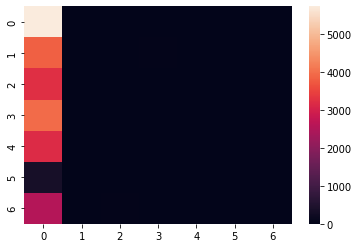



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.25      0.99      0.40      1774
           1       0.00      0.00      0.00      1247
           2       0.11      0.00      0.01      1024
           3       0.23      0.01      0.01      1233
           4       0.00      0.00      0.00       958
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.08      0.14      0.06      7178
weighted avg       0.12      0.25      0.10      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.25      1.00      0.41      1453
           1       0.00      0.00      0.00       970
           2       0.14      0.00      0.00       832
           3       0.06      0.00      0.00       987
           4       0.00      0.00      0.00       803
           5       0.00      0.00      0.00        94
           6       0.00      0.00      0.00       603

    accuracy                           0.25      5742
   macro avg       0.07      0.14      0.06      5742
weighted avg       0.10      0.25      0.10      5742

############# epoch 2 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.34      0.86      0.49      5762
           1       0.27      0.29      0.28      3860
           2       0.23      0.05      0.08      3265
           3       0.34      0.15      0.21      3978
           4       0.63      0.01      0.01      3192
           5       0.00      0.00      0.00       342
           6       0.56      0.44      0.49      2568

    accuracy                           0.35     22967
   macro avg       0.34      0.26      0.22     22967
weighted avg       0.37      0.35      0.27     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


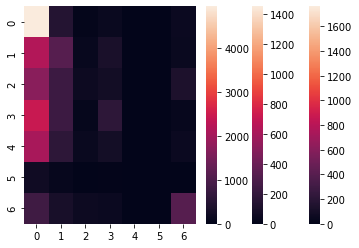



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.35      0.87      0.50      1774
           1       0.28      0.31      0.29      1247
           2       0.22      0.04      0.07      1024
           3       0.34      0.15      0.21      1233
           4       0.57      0.00      0.01       958
           5       0.00      0.00      0.00       111
           6       0.55      0.43      0.48       831

    accuracy                           0.35      7178
   macro avg       0.33      0.26      0.22      7178
weighted avg       0.36      0.35      0.28      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.35      0.84      0.49      1453
           1       0.25      0.29      0.27       970
           2       0.20      0.04      0.06       832
           3       0.33      0.14      0.20       987
           4       0.50      0.00      0.01       803
           5       0.00      0.00      0.00        94
           6       0.54      0.43      0.48       603

    accuracy                           0.34      5742
   macro avg       0.31      0.25      0.22      5742
weighted avg       0.34      0.34      0.26      5742

############# epoch 3 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.52      0.66      0.58      5762
           1       0.29      0.30      0.30      3860
           2       0.21      0.21      0.21      3265
           3       0.34      0.37      0.35      3978
           4       0.38      0.10      0.16      3192
           5       0.00      0.00      0.00       342
           6       0.45      0.59      0.51      2568

    accuracy                           0.39     22967
   macro avg       0.32      0.32      0.30     22967
weighted avg       0.37      0.39      0.37     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


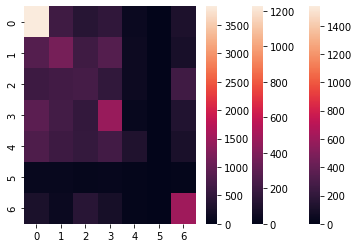



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.52      0.66      0.58      1774
           1       0.31      0.32      0.31      1247
           2       0.21      0.22      0.22      1024
           3       0.34      0.36      0.35      1233
           4       0.38      0.09      0.15       958
           5       0.00      0.00      0.00       111
           6       0.46      0.59      0.52       831

    accuracy                           0.39      7178
   macro avg       0.32      0.32      0.30      7178
weighted avg       0.38      0.39      0.37      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.52      0.66      0.58      1453
           1       0.26      0.27      0.27       970
           2       0.21      0.20      0.21       832
           3       0.32      0.33      0.32       987
           4       0.31      0.09      0.13       803
           5       0.00      0.00      0.00        94
           6       0.43      0.59      0.50       603

    accuracy                           0.37      5742
   macro avg       0.29      0.31      0.29      5742
weighted avg       0.35      0.37      0.35      5742

############# epoch 4 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.53      0.72      0.61      5762
           1       0.35      0.15      0.22      3860
           2       0.24      0.10      0.14      3265
           3       0.34      0.51      0.41      3978
           4       0.32      0.23      0.27      3192
           5       0.00      0.00      0.00       342
           6       0.44      0.65      0.53      2568

    accuracy                           0.41     22967
   macro avg       0.32      0.34      0.31     22967
weighted avg       0.38      0.41      0.38     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


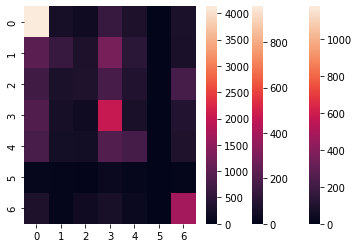



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.52      0.71      0.60      1774
           1       0.36      0.16      0.22      1247
           2       0.25      0.11      0.16      1024
           3       0.32      0.48      0.39      1233
           4       0.29      0.21      0.24       958
           5       0.00      0.00      0.00       111
           6       0.44      0.64      0.52       831

    accuracy                           0.41      7178
   macro avg       0.31      0.33      0.30      7178
weighted avg       0.37      0.41      0.37      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.52      0.69      0.59      1453
           1       0.29      0.14      0.19       970
           2       0.23      0.10      0.14       832
           3       0.33      0.49      0.39       987
           4       0.29      0.23      0.25       803
           5       0.00      0.00      0.00        94
           6       0.41      0.64      0.50       603

    accuracy                           0.39      5742
   macro avg       0.30      0.33      0.29      5742
weighted avg       0.35      0.39      0.36      5742

############# epoch 5 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.44      0.86      0.58      5762
           1       0.33      0.21      0.26      3860
           2       0.32      0.04      0.08      3265
           3       0.35      0.53      0.42      3978
           4       0.46      0.08      0.14      3192
           5       0.00      0.00      0.00       342
           6       0.63      0.50      0.56      2568

    accuracy                           0.42     22967
   macro avg       0.36      0.32      0.29     22967
weighted avg       0.40      0.42      0.35     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


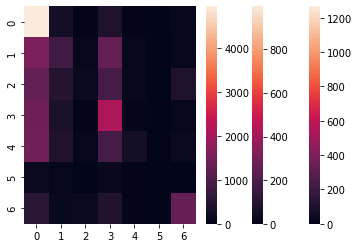



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.43      0.85      0.57      1774
           1       0.31      0.20      0.25      1247
           2       0.35      0.05      0.09      1024
           3       0.33      0.51      0.40      1233
           4       0.43      0.08      0.14       958
           5       0.00      0.00      0.00       111
           6       0.63      0.50      0.56       831

    accuracy                           0.41      7178
   macro avg       0.36      0.31      0.29      7178
weighted avg       0.40      0.41      0.35      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.44      0.85      0.58      1453
           1       0.29      0.19      0.23       970
           2       0.32      0.04      0.08       832
           3       0.34      0.51      0.41       987
           4       0.42      0.08      0.14       803
           5       0.00      0.00      0.00        94
           6       0.60      0.49      0.54       603

    accuracy                           0.40      5742
   macro avg       0.34      0.31      0.28      5742
weighted avg       0.38      0.40      0.34      5742

############# epoch 6 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.52      0.79      0.62      5762
           1       0.33      0.34      0.33      3860
           2       0.29      0.15      0.20      3265
           3       0.43      0.43      0.43      3978
           4       0.37      0.26      0.31      3192
           5       0.00      0.00      0.00       342
           6       0.63      0.54      0.58      2568

    accuracy                           0.45     22967
   macro avg       0.37      0.36      0.35     22967
weighted avg       0.42      0.45      0.42     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


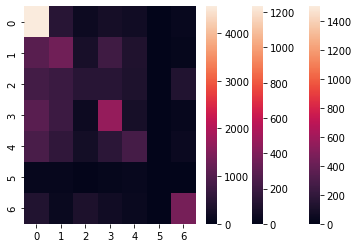



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.51      0.79      0.62      1774
           1       0.33      0.35      0.34      1247
           2       0.31      0.15      0.20      1024
           3       0.42      0.42      0.42      1233
           4       0.32      0.23      0.27       958
           5       0.00      0.00      0.00       111
           6       0.65      0.54      0.59       831

    accuracy                           0.44      7178
   macro avg       0.36      0.35      0.35      7178
weighted avg       0.42      0.44      0.42      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.50      0.77      0.61      1453
           1       0.30      0.32      0.31       970
           2       0.29      0.14      0.19       832
           3       0.41      0.40      0.40       987
           4       0.32      0.24      0.28       803
           5       0.00      0.00      0.00        94
           6       0.60      0.51      0.55       603

    accuracy                           0.42      5742
   macro avg       0.35      0.34      0.33      5742
weighted avg       0.40      0.42      0.40      5742

############# epoch 7 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.70      0.65      5762
           1       0.30      0.51      0.38      3860
           2       0.33      0.12      0.18      3265
           3       0.41      0.49      0.45      3978
           4       0.37      0.25      0.30      3192
           5       0.00      0.00      0.00       342
           6       0.73      0.48      0.57      2568

    accuracy                           0.45     22967
   macro avg       0.39      0.37      0.36     22967
weighted avg       0.46      0.45      0.44     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


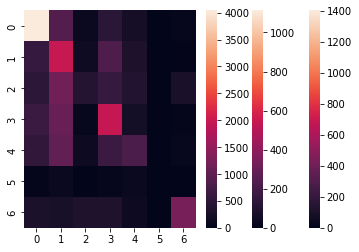



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.69      0.64      1774
           1       0.30      0.50      0.37      1247
           2       0.30      0.10      0.15      1024
           3       0.38      0.47      0.42      1233
           4       0.32      0.21      0.25       958
           5       0.00      0.00      0.00       111
           6       0.72      0.46      0.57       831

    accuracy                           0.43      7178
   macro avg       0.37      0.35      0.34      7178
weighted avg       0.43      0.43      0.42      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.66      0.63      1453
           1       0.28      0.49      0.36       970
           2       0.32      0.11      0.16       832
           3       0.38      0.46      0.42       987
           4       0.34      0.25      0.29       803
           5       0.00      0.00      0.00        94
           6       0.69      0.44      0.54       603

    accuracy                           0.43      5742
   macro avg       0.37      0.34      0.34      5742
weighted avg       0.43      0.43      0.41      5742

############# epoch 8 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.55      0.78      0.65      5762
           1       0.35      0.32      0.33      3860
           2       0.32      0.12      0.18      3265
           3       0.43      0.48      0.46      3978
           4       0.36      0.36      0.36      3192
           5       0.00      0.00      0.00       342
           6       0.63      0.60      0.61      2568

    accuracy                           0.47     22967
   macro avg       0.38      0.38      0.37     22967
weighted avg       0.44      0.47      0.44     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


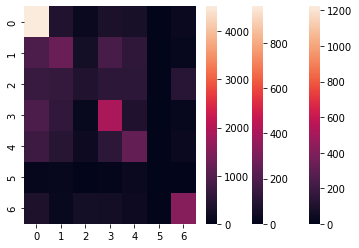



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.54      0.78      0.63      1774
           1       0.35      0.31      0.33      1247
           2       0.28      0.10      0.15      1024
           3       0.40      0.45      0.42      1233
           4       0.31      0.31      0.31       958
           5       0.00      0.00      0.00       111
           6       0.62      0.59      0.61       831

    accuracy                           0.45      7178
   macro avg       0.36      0.36      0.35      7178
weighted avg       0.41      0.45      0.42      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.53      0.75      0.62      1453
           1       0.33      0.31      0.32       970
           2       0.31      0.10      0.15       832
           3       0.40      0.42      0.41       987
           4       0.31      0.34      0.33       803
           5       0.00      0.00      0.00        94
           6       0.59      0.57      0.58       603

    accuracy                           0.44      5742
   macro avg       0.35      0.36      0.34      5742
weighted avg       0.41      0.44      0.41      5742

############# epoch 9 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.69      0.67      5762
           1       0.35      0.34      0.34      3860
           2       0.28      0.20      0.23      3265
           3       0.39      0.61      0.48      3978
           4       0.45      0.23      0.30      3192
           5       0.00      0.00      0.00       342
           6       0.57      0.68      0.62      2568

    accuracy                           0.47     22967
   macro avg       0.39      0.39      0.38     22967
weighted avg       0.46      0.47      0.45     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


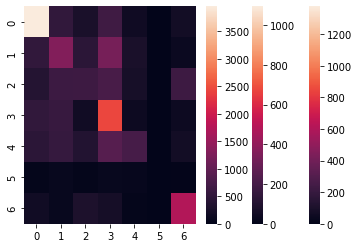



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.68      0.66      1774
           1       0.33      0.32      0.33      1247
           2       0.24      0.15      0.19      1024
           3       0.37      0.58      0.45      1233
           4       0.36      0.19      0.25       958
           5       0.00      0.00      0.00       111
           6       0.55      0.67      0.61       831

    accuracy                           0.45      7178
   macro avg       0.36      0.37      0.35      7178
weighted avg       0.43      0.45      0.43      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.67      0.65      1453
           1       0.31      0.31      0.31       970
           2       0.28      0.18      0.22       832
           3       0.35      0.53      0.42       987
           4       0.38      0.22      0.27       803
           5       0.00      0.00      0.00        94
           6       0.53      0.66      0.58       603

    accuracy                           0.44      5742
   macro avg       0.35      0.37      0.35      5742
weighted avg       0.42      0.44      0.42      5742

############# epoch 10 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.69      0.67      5762
           1       0.34      0.41      0.37      3860
           2       0.32      0.16      0.21      3265
           3       0.40      0.59      0.48      3978
           4       0.42      0.27      0.33      3192
           5       0.00      0.00      0.00       342
           6       0.61      0.65      0.63      2568

    accuracy                           0.48     22967
   macro avg       0.39      0.39      0.38     22967
weighted avg       0.46      0.48      0.46     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


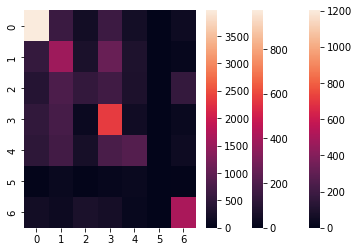



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.69      0.66      1774
           1       0.32      0.38      0.35      1247
           2       0.27      0.13      0.18      1024
           3       0.38      0.55      0.45      1233
           4       0.36      0.23      0.28       958
           5       0.00      0.00      0.00       111
           6       0.61      0.63      0.62       831

    accuracy                           0.45      7178
   macro avg       0.37      0.37      0.36      7178
weighted avg       0.43      0.45      0.43      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.67      0.65      1453
           1       0.32      0.39      0.35       970
           2       0.29      0.13      0.18       832
           3       0.38      0.52      0.44       987
           4       0.36      0.26      0.30       803
           5       0.00      0.00      0.00        94
           6       0.56      0.62      0.59       603

    accuracy                           0.45      5742
   macro avg       0.36      0.37      0.36      5742
weighted avg       0.43      0.45      0.43      5742

############# epoch 11 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.58      0.78      0.67      5762
           1       0.37      0.35      0.36      3860
           2       0.30      0.20      0.24      3265
           3       0.48      0.43      0.45      3978
           4       0.40      0.32      0.36      3192
           5       0.00      0.00      0.00       342
           6       0.55      0.71      0.62      2568

    accuracy                           0.48     22967
   macro avg       0.38      0.40      0.39     22967
weighted avg       0.45      0.48      0.46     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


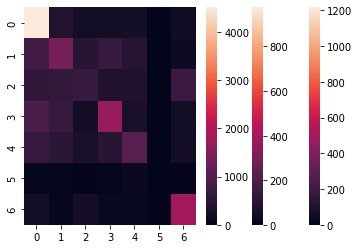



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.57      0.78      0.66      1774
           1       0.35      0.33      0.34      1247
           2       0.25      0.15      0.19      1024
           3       0.44      0.39      0.41      1233
           4       0.34      0.28      0.31       958
           5       0.00      0.00      0.00       111
           6       0.54      0.70      0.61       831

    accuracy                           0.46      7178
   macro avg       0.36      0.37      0.36      7178
weighted avg       0.42      0.46      0.43      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.57      0.76      0.65      1453
           1       0.33      0.33      0.33       970
           2       0.27      0.16      0.20       832
           3       0.44      0.37      0.40       987
           4       0.34      0.29      0.32       803
           5       0.00      0.00      0.00        94
           6       0.50      0.70      0.58       603

    accuracy                           0.45      5742
   macro avg       0.35      0.37      0.35      5742
weighted avg       0.41      0.45      0.42      5742

############# epoch 12 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.76      0.68      5762
           1       0.37      0.35      0.36      3860
           2       0.34      0.17      0.23      3265
           3       0.42      0.59      0.49      3978
           4       0.42      0.31      0.36      3192
           5       0.00      0.00      0.00       342
           6       0.64      0.65      0.65      2568

    accuracy                           0.49     22967
   macro avg       0.40      0.40      0.40     22967
weighted avg       0.47      0.49      0.47     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


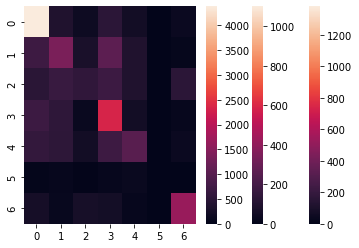



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.75      0.66      1774
           1       0.35      0.33      0.34      1247
           2       0.29      0.14      0.19      1024
           3       0.38      0.54      0.44      1233
           4       0.36      0.26      0.30       958
           5       0.00      0.00      0.00       111
           6       0.62      0.63      0.62       831

    accuracy                           0.46      7178
   macro avg       0.37      0.38      0.37      7178
weighted avg       0.43      0.46      0.44      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.73      0.65      1453
           1       0.32      0.32      0.32       970
           2       0.28      0.13      0.17       832
           3       0.39      0.52      0.45       987
           4       0.36      0.29      0.32       803
           5       0.00      0.00      0.00        94
           6       0.59      0.61      0.60       603

    accuracy                           0.45      5742
   macro avg       0.36      0.37      0.36      5742
weighted avg       0.42      0.45      0.43      5742

############# epoch 13 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.75      0.69      5762
           1       0.36      0.42      0.39      3860
           2       0.35      0.18      0.24      3265
           3       0.43      0.59      0.49      3978
           4       0.44      0.27      0.34      3192
           5       0.00      0.00      0.00       342
           6       0.64      0.65      0.65      2568

    accuracy                           0.50     22967
   macro avg       0.41      0.41      0.40     22967
weighted avg       0.48      0.50      0.48     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


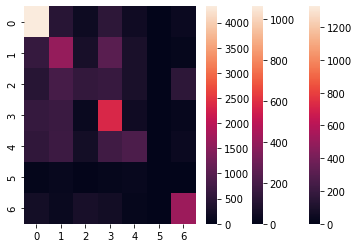



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      1774
           1       0.34      0.39      0.36      1247
           2       0.30      0.15      0.20      1024
           3       0.40      0.54      0.46      1233
           4       0.37      0.23      0.28       958
           5       0.00      0.00      0.00       111
           6       0.63      0.63      0.63       831

    accuracy                           0.47      7178
   macro avg       0.38      0.38      0.37      7178
weighted avg       0.44      0.47      0.45      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.71      0.66      1453
           1       0.33      0.39      0.35       970
           2       0.29      0.13      0.18       832
           3       0.39      0.52      0.45       987
           4       0.38      0.25      0.30       803
           5       0.00      0.00      0.00        94
           6       0.59      0.62      0.61       603

    accuracy                           0.46      5742
   macro avg       0.37      0.38      0.36      5742
weighted avg       0.43      0.46      0.44      5742

############# epoch 14 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.78      0.68      5762
           1       0.37      0.39      0.38      3860
           2       0.39      0.13      0.19      3265
           3       0.42      0.56      0.48      3978
           4       0.39      0.38      0.38      3192
           5       0.00      0.00      0.00       342
           6       0.72      0.55      0.62      2568

    accuracy                           0.49     22967
   macro avg       0.41      0.40      0.39     22967
weighted avg       0.48      0.49      0.47     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


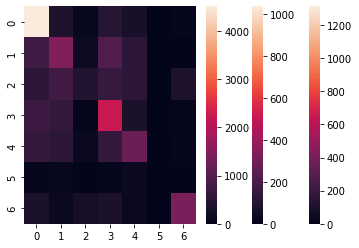



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.58      0.77      0.66      1774
           1       0.34      0.35      0.35      1247
           2       0.35      0.11      0.16      1024
           3       0.39      0.51      0.44      1233
           4       0.33      0.33      0.33       958
           5       0.00      0.00      0.00       111
           6       0.71      0.55      0.62       831

    accuracy                           0.46      7178
   macro avg       0.38      0.37      0.36      7178
weighted avg       0.44      0.46      0.44      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.58      0.75      0.66      1453
           1       0.34      0.36      0.35       970
           2       0.30      0.08      0.13       832
           3       0.39      0.49      0.44       987
           4       0.34      0.37      0.35       803
           5       0.00      0.00      0.00        94
           6       0.66      0.51      0.58       603

    accuracy                           0.45      5742
   macro avg       0.37      0.37      0.36      5742
weighted avg       0.43      0.45      0.43      5742

############# epoch 15 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.77      0.69      5762
           1       0.39      0.35      0.37      3860
           2       0.36      0.17      0.23      3265
           3       0.45      0.54      0.49      3978
           4       0.38      0.42      0.40      3192
           5       0.00      0.00      0.00       342
           6       0.64      0.66      0.65      2568

    accuracy                           0.50     22967
   macro avg       0.41      0.42      0.40     22967
weighted avg       0.48      0.50      0.48     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


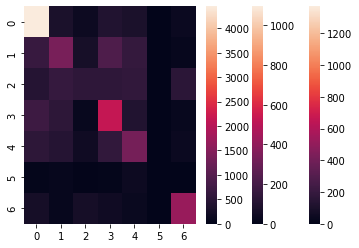



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.76      0.68      1774
           1       0.35      0.32      0.34      1247
           2       0.29      0.12      0.17      1024
           3       0.41      0.49      0.44      1233
           4       0.33      0.36      0.34       958
           5       0.00      0.00      0.00       111
           6       0.63      0.65      0.64       831

    accuracy                           0.47      7178
   macro avg       0.37      0.39      0.37      7178
weighted avg       0.44      0.47      0.45      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.73      0.66      1453
           1       0.33      0.31      0.32       970
           2       0.30      0.12      0.17       832
           3       0.41      0.46      0.43       987
           4       0.34      0.41      0.37       803
           5       0.00      0.00      0.00        94
           6       0.58      0.62      0.60       603

    accuracy                           0.46      5742
   macro avg       0.37      0.38      0.37      5742
weighted avg       0.43      0.46      0.44      5742

############# epoch 16 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.76      0.70      5762
           1       0.39      0.41      0.40      3860
           2       0.34      0.22      0.27      3265
           3       0.47      0.50      0.49      3978
           4       0.41      0.38      0.39      3192
           5       0.00      0.00      0.00       342
           6       0.62      0.68      0.65      2568

    accuracy                           0.51     22967
   macro avg       0.41      0.42      0.41     22967
weighted avg       0.48      0.51      0.49     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


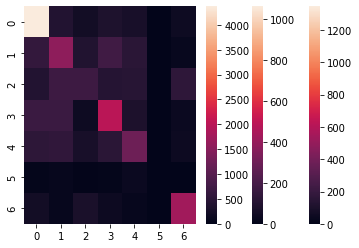



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.75      0.68      1774
           1       0.35      0.37      0.36      1247
           2       0.27      0.17      0.21      1024
           3       0.43      0.45      0.44      1233
           4       0.35      0.32      0.33       958
           5       0.00      0.00      0.00       111
           6       0.61      0.67      0.64       831

    accuracy                           0.47      7178
   macro avg       0.38      0.39      0.38      7178
weighted avg       0.44      0.47      0.45      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1453
           1       0.33      0.35      0.34       970
           2       0.29      0.18      0.22       832
           3       0.43      0.43      0.43       987
           4       0.35      0.36      0.36       803
           5       0.00      0.00      0.00        94
           6       0.57      0.66      0.61       603

    accuracy                           0.46      5742
   macro avg       0.37      0.38      0.37      5742
weighted avg       0.44      0.46      0.44      5742

############# epoch 17 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.78      0.70      5762
           1       0.41      0.34      0.37      3860
           2       0.35      0.20      0.26      3265
           3       0.45      0.56      0.50      3978
           4       0.42      0.35      0.38      3192
           5       0.00      0.00      0.00       342
           6       0.60      0.71      0.65      2568

    accuracy                           0.51     22967
   macro avg       0.41      0.42      0.41     22967
weighted avg       0.48      0.51      0.48     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


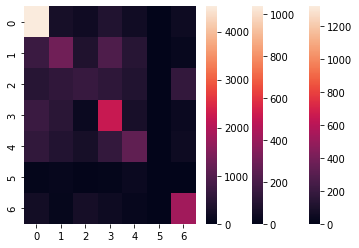



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.76      0.67      1774
           1       0.36      0.30      0.33      1247
           2       0.29      0.16      0.21      1024
           3       0.41      0.51      0.45      1233
           4       0.35      0.31      0.33       958
           5       0.00      0.00      0.00       111
           6       0.60      0.69      0.64       831

    accuracy                           0.47      7178
   macro avg       0.37      0.39      0.38      7178
weighted avg       0.44      0.47      0.45      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.75      0.67      1453
           1       0.35      0.29      0.32       970
           2       0.29      0.16      0.20       832
           3       0.41      0.48      0.44       987
           4       0.37      0.35      0.36       803
           5       0.00      0.00      0.00        94
           6       0.55      0.67      0.60       603

    accuracy                           0.46      5742
   macro avg       0.37      0.38      0.37      5742
weighted avg       0.43      0.46      0.44      5742

############# epoch 18 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.79      0.70      5762
           1       0.36      0.50      0.42      3860
           2       0.36      0.21      0.27      3265
           3       0.49      0.48      0.49      3978
           4       0.44      0.33      0.38      3192
           5       0.00      0.00      0.00       342
           6       0.72      0.57      0.64      2568

    accuracy                           0.51     22967
   macro avg       0.43      0.41      0.41     22967
weighted avg       0.49      0.51      0.49     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


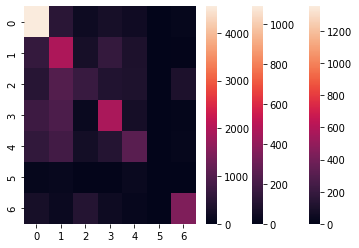



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.77      0.67      1774
           1       0.33      0.45      0.38      1247
           2       0.30      0.17      0.21      1024
           3       0.44      0.44      0.44      1233
           4       0.36      0.28      0.31       958
           5       0.00      0.00      0.00       111
           6       0.70      0.57      0.62       831

    accuracy                           0.47      7178
   macro avg       0.39      0.38      0.38      7178
weighted avg       0.45      0.47      0.45      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.59      0.75      0.66      1453
           1       0.32      0.46      0.37       970
           2       0.30      0.16      0.21       832
           3       0.45      0.42      0.43       987
           4       0.37      0.31      0.34       803
           5       0.00      0.00      0.00        94
           6       0.65      0.53      0.58       603

    accuracy                           0.46      5742
   macro avg       0.38      0.37      0.37      5742
weighted avg       0.44      0.46      0.44      5742

############# epoch 19 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.75      0.70      5762
           1       0.39      0.40      0.40      3860
           2       0.37      0.19      0.25      3265
           3       0.49      0.51      0.50      3978
           4       0.38      0.47      0.42      3192
           5       0.00      0.00      0.00       342
           6       0.65      0.68      0.66      2568

    accuracy                           0.51     22967
   macro avg       0.42      0.43      0.42     22967
weighted avg       0.49      0.51      0.50     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


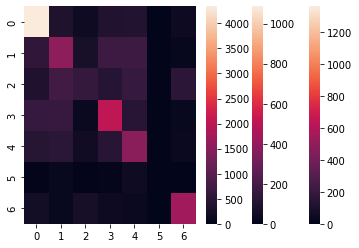



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.73      0.68      1774
           1       0.35      0.35      0.35      1247
           2       0.29      0.14      0.19      1024
           3       0.43      0.45      0.44      1233
           4       0.32      0.41      0.36       958
           5       0.00      0.00      0.00       111
           6       0.63      0.65      0.64       831

    accuracy                           0.47      7178
   macro avg       0.38      0.39      0.38      7178
weighted avg       0.45      0.47      0.45      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.70      0.66      1453
           1       0.33      0.35      0.34       970
           2       0.30      0.13      0.18       832
           3       0.43      0.43      0.43       987
           4       0.32      0.43      0.36       803
           5       0.00      0.00      0.00        94
           6       0.60      0.64      0.62       603

    accuracy                           0.46      5742
   macro avg       0.37      0.38      0.37      5742
weighted avg       0.44      0.46      0.44      5742

############# epoch 20 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.74      0.71      5762
           1       0.40      0.40      0.40      3860
           2       0.35      0.23      0.28      3265
           3       0.45      0.60      0.51      3978
           4       0.46      0.31      0.37      3192
           5       0.00      0.00      0.00       342
           6       0.59      0.73      0.65      2568

    accuracy                           0.51     22967
   macro avg       0.42      0.43      0.42     22967
weighted avg       0.49      0.51      0.50     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


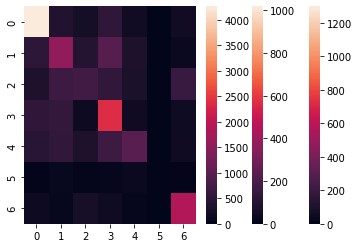



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1774
           1       0.35      0.35      0.35      1247
           2       0.30      0.18      0.22      1024
           3       0.40      0.54      0.46      1233
           4       0.38      0.26      0.31       958
           5       0.00      0.00      0.00       111
           6       0.58      0.71      0.64       831

    accuracy                           0.47      7178
   macro avg       0.38      0.39      0.38      7178
weighted avg       0.45      0.47      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.69      0.66      1453
           1       0.33      0.36      0.35       970
           2       0.30      0.18      0.23       832
           3       0.40      0.51      0.45       987
           4       0.38      0.27      0.32       803
           5       0.00      0.00      0.00        94
           6       0.54      0.68      0.61       603

    accuracy                           0.46      5742
   macro avg       0.37      0.39      0.37      5742
weighted avg       0.44      0.46      0.44      5742

############# epoch 21 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.78      0.70      5762
           1       0.40      0.40      0.40      3860
           2       0.37      0.21      0.27      3265
           3       0.47      0.55      0.51      3978
           4       0.44      0.35      0.39      3192
           5       0.00      0.00      0.00       342
           6       0.59      0.72      0.65      2568

    accuracy                           0.52     22967
   macro avg       0.42      0.43      0.42     22967
weighted avg       0.49      0.52      0.50     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


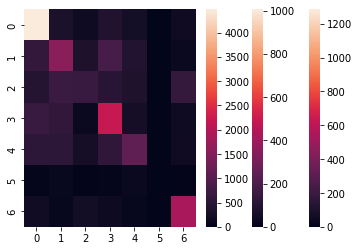



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.76      0.68      1774
           1       0.36      0.35      0.35      1247
           2       0.32      0.17      0.22      1024
           3       0.43      0.48      0.45      1233
           4       0.37      0.30      0.33       958
           5       0.00      0.00      0.00       111
           6       0.57      0.70      0.63       831

    accuracy                           0.48      7178
   macro avg       0.38      0.40      0.38      7178
weighted avg       0.45      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.73      0.67      1453
           1       0.33      0.34      0.33       970
           2       0.32      0.16      0.21       832
           3       0.42      0.46      0.44       987
           4       0.36      0.33      0.34       803
           5       0.00      0.00      0.00        94
           6       0.54      0.69      0.61       603

    accuracy                           0.46      5742
   macro avg       0.37      0.39      0.37      5742
weighted avg       0.43      0.46      0.44      5742

############# epoch 22 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.77      0.71      5762
           1       0.39      0.47      0.43      3860
           2       0.40      0.21      0.27      3265
           3       0.47      0.58      0.52      3978
           4       0.45      0.36      0.40      3192
           5       0.00      0.00      0.00       342
           6       0.68      0.65      0.67      2568

    accuracy                           0.52     22967
   macro avg       0.44      0.43      0.43     22967
weighted avg       0.51      0.52      0.51     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


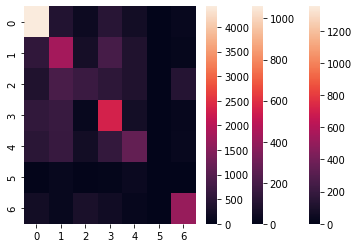



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.74      0.68      1774
           1       0.35      0.40      0.37      1247
           2       0.31      0.16      0.21      1024
           3       0.41      0.52      0.46      1233
           4       0.37      0.30      0.33       958
           5       0.00      0.00      0.00       111
           6       0.66      0.63      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.39      0.39      7178
weighted avg       0.46      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1453
           1       0.33      0.41      0.37       970
           2       0.31      0.14      0.20       832
           3       0.41      0.49      0.45       987
           4       0.37      0.32      0.34       803
           5       0.00      0.00      0.00        94
           6       0.60      0.59      0.60       603

    accuracy                           0.46      5742
   macro avg       0.38      0.38      0.37      5742
weighted avg       0.44      0.46      0.45      5742

############# epoch 23 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.77      0.71      5762
           1       0.37      0.53      0.44      3860
           2       0.40      0.19      0.26      3265
           3       0.50      0.51      0.51      3978
           4       0.42      0.40      0.41      3192
           5       0.00      0.00      0.00       342
           6       0.70      0.63      0.66      2568

    accuracy                           0.52     22967
   macro avg       0.44      0.43      0.43     22967
weighted avg       0.51      0.52      0.51     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


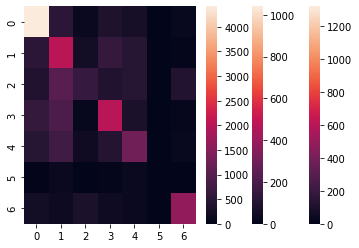



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.74      0.69      1774
           1       0.33      0.46      0.39      1247
           2       0.30      0.14      0.19      1024
           3       0.45      0.45      0.45      1233
           4       0.36      0.33      0.34       958
           5       0.00      0.00      0.00       111
           6       0.67      0.61      0.64       831

    accuracy                           0.48      7178
   macro avg       0.39      0.39      0.39      7178
weighted avg       0.46      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1453
           1       0.32      0.47      0.38       970
           2       0.32      0.13      0.19       832
           3       0.45      0.43      0.44       987
           4       0.36      0.36      0.36       803
           5       0.00      0.00      0.00        94
           6       0.62      0.57      0.59       603

    accuracy                           0.46      5742
   macro avg       0.38      0.38      0.38      5742
weighted avg       0.45      0.46      0.45      5742

############# epoch 24 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.76      0.72      5762
           1       0.40      0.46      0.43      3860
           2       0.37      0.23      0.28      3265
           3       0.47      0.59      0.52      3978
           4       0.46      0.31      0.37      3192
           5       0.00      0.00      0.00       342
           6       0.63      0.70      0.66      2568

    accuracy                           0.52     22967
   macro avg       0.43      0.44      0.43     22967
weighted avg       0.51      0.52      0.51     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


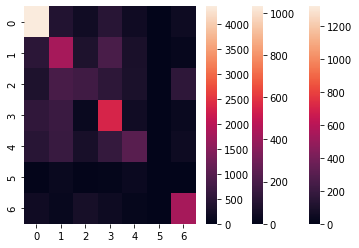



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.74      0.69      1774
           1       0.34      0.39      0.37      1247
           2       0.28      0.16      0.20      1024
           3       0.41      0.52      0.46      1233
           4       0.39      0.27      0.32       958
           5       0.00      0.00      0.00       111
           6       0.61      0.68      0.64       831

    accuracy                           0.48      7178
   macro avg       0.38      0.39      0.38      7178
weighted avg       0.45      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1453
           1       0.33      0.41      0.36       970
           2       0.31      0.17      0.22       832
           3       0.42      0.49      0.45       987
           4       0.38      0.28      0.32       803
           5       0.00      0.00      0.00        94
           6       0.56      0.66      0.61       603

    accuracy                           0.46      5742
   macro avg       0.38      0.39      0.38      5742
weighted avg       0.45      0.46      0.45      5742

############# epoch 25 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.77      0.72      5762
           1       0.40      0.47      0.43      3860
           2       0.39      0.23      0.29      3265
           3       0.46      0.60      0.52      3978
           4       0.46      0.33      0.39      3192
           5       0.00      0.00      0.00       342
           6       0.68      0.66      0.67      2568

    accuracy                           0.53     22967
   macro avg       0.44      0.44      0.43     22967
weighted avg       0.51      0.53      0.51     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


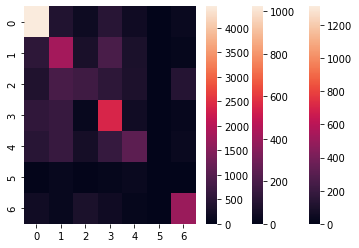



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1774
           1       0.35      0.40      0.37      1247
           2       0.30      0.17      0.22      1024
           3       0.41      0.52      0.46      1233
           4       0.39      0.28      0.33       958
           5       0.00      0.00      0.00       111
           6       0.65      0.64      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.39      0.39      7178
weighted avg       0.46      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1453
           1       0.32      0.41      0.36       970
           2       0.32      0.16      0.21       832
           3       0.41      0.50      0.45       987
           4       0.38      0.29      0.33       803
           5       0.00      0.00      0.00        94
           6       0.60      0.61      0.60       603

    accuracy                           0.46      5742
   macro avg       0.38      0.38      0.38      5742
weighted avg       0.45      0.46      0.45      5742

############# epoch 26 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.77      0.72      5762
           1       0.40      0.47      0.43      3860
           2       0.40      0.20      0.27      3265
           3       0.47      0.59      0.52      3978
           4       0.45      0.36      0.40      3192
           5       0.00      0.00      0.00       342
           6       0.67      0.67      0.67      2568

    accuracy                           0.53     22967
   macro avg       0.44      0.44      0.43     22967
weighted avg       0.51      0.53      0.51     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


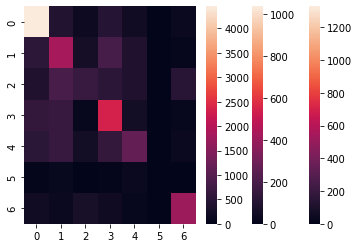



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1774
           1       0.35      0.41      0.37      1247
           2       0.31      0.15      0.20      1024
           3       0.42      0.52      0.46      1233
           4       0.38      0.30      0.33       958
           5       0.00      0.00      0.00       111
           6       0.64      0.64      0.64       831

    accuracy                           0.48      7178
   macro avg       0.39      0.39      0.39      7178
weighted avg       0.46      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1453
           1       0.33      0.43      0.38       970
           2       0.33      0.15      0.20       832
           3       0.41      0.49      0.45       987
           4       0.38      0.32      0.35       803
           5       0.00      0.00      0.00        94
           6       0.60      0.62      0.61       603

    accuracy                           0.47      5742
   macro avg       0.38      0.39      0.38      5742
weighted avg       0.45      0.47      0.45      5742

############# epoch 27 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.78      0.72      5762
           1       0.41      0.46      0.43      3860
           2       0.40      0.19      0.26      3265
           3       0.47      0.61      0.53      3978
           4       0.44      0.39      0.41      3192
           5       0.00      0.00      0.00       342
           6       0.70      0.64      0.67      2568

    accuracy                           0.53     22967
   macro avg       0.44      0.44      0.43     22967
weighted avg       0.51      0.53      0.51     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


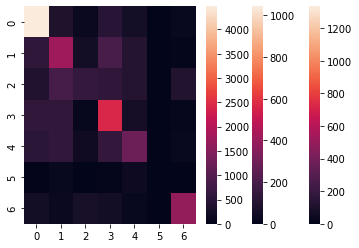



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.75      0.68      1774
           1       0.35      0.38      0.36      1247
           2       0.31      0.14      0.20      1024
           3       0.40      0.53      0.45      1233
           4       0.36      0.32      0.34       958
           5       0.00      0.00      0.00       111
           6       0.68      0.62      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.39      0.38      7178
weighted avg       0.46      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.72      0.66      1453
           1       0.33      0.40      0.37       970
           2       0.31      0.13      0.19       832
           3       0.40      0.50      0.45       987
           4       0.36      0.34      0.35       803
           5       0.00      0.00      0.00        94
           6       0.62      0.58      0.60       603

    accuracy                           0.46      5742
   macro avg       0.38      0.38      0.37      5742
weighted avg       0.44      0.46      0.45      5742

############# epoch 28 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.71      0.74      0.73      5762
           1       0.41      0.45      0.43      3860
           2       0.39      0.22      0.28      3265
           3       0.47      0.62      0.53      3978
           4       0.43      0.39      0.41      3192
           5       0.00      0.00      0.00       342
           6       0.63      0.71      0.67      2568

    accuracy                           0.53     22967
   macro avg       0.44      0.45      0.44     22967
weighted avg       0.52      0.53      0.52     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


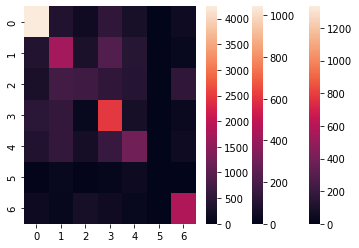



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1774
           1       0.35      0.37      0.36      1247
           2       0.29      0.15      0.20      1024
           3       0.40      0.54      0.46      1233
           4       0.36      0.33      0.34       958
           5       0.00      0.00      0.00       111
           6       0.62      0.68      0.65       831

    accuracy                           0.48      7178
   macro avg       0.38      0.40      0.39      7178
weighted avg       0.46      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1453
           1       0.33      0.39      0.36       970
           2       0.32      0.17      0.22       832
           3       0.40      0.50      0.44       987
           4       0.35      0.34      0.35       803
           5       0.00      0.00      0.00        94
           6       0.57      0.65      0.61       603

    accuracy                           0.46      5742
   macro avg       0.38      0.39      0.38      5742
weighted avg       0.45      0.46      0.45      5742

############# epoch 29 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.81      0.71      5762
           1       0.40      0.49      0.44      3860
           2       0.41      0.21      0.27      3265
           3       0.51      0.53      0.52      3978
           4       0.43      0.40      0.41      3192
           5       0.00      0.00      0.00       342
           6       0.72      0.63      0.67      2568

    accuracy                           0.53     22967
   macro avg       0.45      0.44      0.43     22967
weighted avg       0.52      0.53      0.52     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


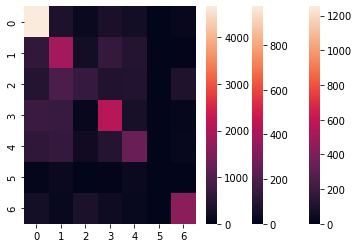



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.78      0.68      1774
           1       0.34      0.42      0.38      1247
           2       0.31      0.15      0.20      1024
           3       0.45      0.47      0.46      1233
           4       0.35      0.33      0.34       958
           5       0.00      0.00      0.00       111
           6       0.69      0.61      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.39      0.39      7178
weighted avg       0.46      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.76      0.67      1453
           1       0.33      0.43      0.37       970
           2       0.32      0.14      0.20       832
           3       0.45      0.43      0.44       987
           4       0.36      0.35      0.36       803
           5       0.00      0.00      0.00        94
           6       0.63      0.57      0.60       603

    accuracy                           0.47      5742
   macro avg       0.38      0.38      0.38      5742
weighted avg       0.45      0.47      0.45      5742

############# epoch 30 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.79      0.72      5762
           1       0.41      0.45      0.43      3860
           2       0.41      0.22      0.29      3265
           3       0.48      0.58      0.52      3978
           4       0.44      0.38      0.41      3192
           5       0.00      0.00      0.00       342
           6       0.68      0.68      0.68      2568

    accuracy                           0.53     22967
   macro avg       0.44      0.44      0.43     22967
weighted avg       0.51      0.53      0.52     22967



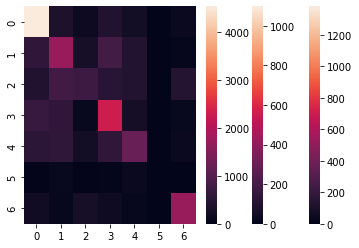



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.76      0.68      1774
           1       0.34      0.37      0.35      1247
           2       0.30      0.16      0.21      1024
           3       0.41      0.50      0.45      1233
           4       0.37      0.32      0.34       958
           5       0.00      0.00      0.00       111
           6       0.65      0.64      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.39      0.38      7178
weighted avg       0.45      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.73      0.67      1453
           1       0.34      0.39      0.36       970
           2       0.34      0.16      0.22       832
           3       0.42      0.48      0.45       987
           4       0.36      0.33      0.35       803
           5       0.00      0.00      0.00        94
           6       0.60      0.62      0.61       603

    accuracy                           0.47      5742
   macro avg       0.38      0.39      0.38      5742
weighted avg       0.45      0.47      0.45      5742

############# epoch 31 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.70      0.75      0.72      5762
           1       0.40      0.50      0.44      3860
           2       0.41      0.22      0.29      3265
           3       0.47      0.59      0.53      3978
           4       0.43      0.41      0.42      3192
           5       0.50      0.00      0.01       342
           6       0.72      0.63      0.67      2568

    accuracy                           0.53     22967
   macro avg       0.52      0.44      0.44     22967
weighted avg       0.53      0.53      0.52     22967



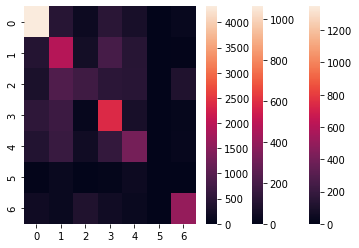



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.72      0.69      1774
           1       0.34      0.43      0.38      1247
           2       0.31      0.16      0.21      1024
           3       0.42      0.53      0.47      1233
           4       0.36      0.34      0.35       958
           5       0.00      0.00      0.00       111
           6       0.69      0.61      0.65       831

    accuracy                           0.48      7178
   macro avg       0.40      0.40      0.39      7178
weighted avg       0.47      0.48      0.47      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.68      0.67      1453
           1       0.33      0.45      0.38       970
           2       0.32      0.16      0.21       832
           3       0.42      0.49      0.45       987
           4       0.36      0.36      0.36       803
           5       0.00      0.00      0.00        94
           6       0.64      0.57      0.60       603

    accuracy                           0.46      5742
   macro avg       0.39      0.39      0.38      5742
weighted avg       0.46      0.46      0.45      5742

############# epoch 32 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.78      0.72      5762
           1       0.42      0.45      0.43      3860
           2       0.41      0.23      0.29      3265
           3       0.49      0.58      0.53      3978
           4       0.44      0.39      0.41      3192
           5       0.00      0.00      0.00       342
           6       0.65      0.71      0.68      2568

    accuracy                           0.54     22967
   macro avg       0.44      0.45      0.44     22967
weighted avg       0.52      0.54      0.52     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


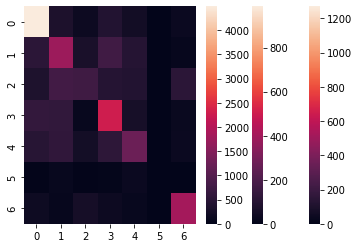



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1774
           1       0.36      0.38      0.37      1247
           2       0.30      0.17      0.21      1024
           3       0.42      0.49      0.45      1233
           4       0.37      0.33      0.35       958
           5       0.00      0.00      0.00       111
           6       0.61      0.68      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.46      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1453
           1       0.33      0.38      0.36       970
           2       0.33      0.18      0.23       832
           3       0.43      0.48      0.45       987
           4       0.36      0.35      0.36       803
           5       0.00      0.00      0.00        94
           6       0.57      0.66      0.61       603

    accuracy                           0.47      5742
   macro avg       0.38      0.39      0.38      5742
weighted avg       0.45      0.47      0.45      5742

############# epoch 33 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.79      0.72      5762
           1       0.41      0.48      0.44      3860
           2       0.40      0.25      0.31      3265
           3       0.52      0.54      0.53      3978
           4       0.44      0.39      0.41      3192
           5       0.00      0.00      0.00       342
           6       0.67      0.68      0.68      2568

    accuracy                           0.54     22967
   macro avg       0.44      0.45      0.44     22967
weighted avg       0.52      0.54      0.52     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


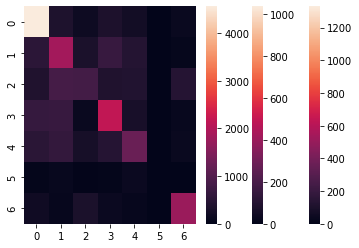



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.76      0.69      1774
           1       0.35      0.40      0.37      1247
           2       0.29      0.17      0.22      1024
           3       0.45      0.47      0.46      1233
           4       0.37      0.32      0.34       958
           5       0.00      0.00      0.00       111
           6       0.64      0.66      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.46      0.48      0.47      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1453
           1       0.33      0.41      0.37       970
           2       0.33      0.19      0.24       832
           3       0.44      0.43      0.44       987
           4       0.36      0.34      0.35       803
           5       0.00      0.00      0.00        94
           6       0.59      0.63      0.61       603

    accuracy                           0.47      5742
   macro avg       0.38      0.39      0.38      5742
weighted avg       0.45      0.47      0.45      5742

############# epoch 34 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.68      0.77      0.72      5762
           1       0.41      0.49      0.45      3860
           2       0.41      0.23      0.29      3265
           3       0.50      0.58      0.53      3978
           4       0.44      0.39      0.41      3192
           5       1.00      0.00      0.01       342
           6       0.69      0.67      0.68      2568

    accuracy                           0.54     22967
   macro avg       0.59      0.45      0.44     22967
weighted avg       0.54      0.54      0.52     22967



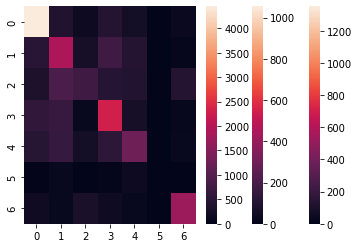



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.74      0.69      1774
           1       0.35      0.41      0.38      1247
           2       0.29      0.16      0.21      1024
           3       0.42      0.49      0.46      1233
           4       0.37      0.33      0.35       958
           5       0.00      0.00      0.00       111
           6       0.65      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.46      0.48      0.47      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.71      0.67      1453
           1       0.33      0.43      0.38       970
           2       0.32      0.16      0.22       832
           3       0.42      0.46      0.44       987
           4       0.37      0.34      0.35       803
           5       0.00      0.00      0.00        94
           6       0.60      0.62      0.61       603

    accuracy                           0.47      5742
   macro avg       0.38      0.39      0.38      5742
weighted avg       0.45      0.47      0.45      5742

############# epoch 35 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.79      0.72      5762
           1       0.41      0.50      0.45      3860
           2       0.42      0.23      0.29      3265
           3       0.52      0.55      0.53      3978
           4       0.44      0.41      0.42      3192
           5       0.00      0.00      0.00       342
           6       0.69      0.67      0.68      2568

    accuracy                           0.54     22967
   macro avg       0.45      0.45      0.44     22967
weighted avg       0.52      0.54      0.53     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


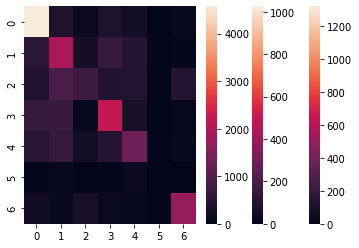



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.76      0.69      1774
           1       0.35      0.42      0.38      1247
           2       0.30      0.16      0.21      1024
           3       0.44      0.47      0.46      1233
           4       0.37      0.34      0.35       958
           5       0.00      0.00      0.00       111
           6       0.66      0.64      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.46      0.48      0.47      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1453
           1       0.33      0.42      0.37       970
           2       0.33      0.16      0.22       832
           3       0.44      0.44      0.44       987
           4       0.36      0.35      0.35       803
           5       0.00      0.00      0.00        94
           6       0.61      0.61      0.61       603

    accuracy                           0.47      5742
   macro avg       0.38      0.39      0.38      5742
weighted avg       0.45      0.47      0.45      5742

############# epoch 36 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.78      0.72      5762
           1       0.42      0.45      0.43      3860
           2       0.41      0.24      0.30      3265
           3       0.49      0.58      0.53      3978
           4       0.45      0.39      0.42      3192
           5       0.50      0.00      0.01       342
           6       0.68      0.69      0.68      2568

    accuracy                           0.54     22967
   macro avg       0.52      0.45      0.44     22967
weighted avg       0.53      0.54      0.52     22967



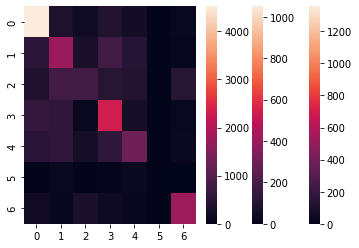



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.76      0.69      1774
           1       0.36      0.38      0.37      1247
           2       0.28      0.16      0.21      1024
           3       0.42      0.50      0.46      1233
           4       0.37      0.33      0.35       958
           5       0.00      0.00      0.00       111
           6       0.64      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.46      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1453
           1       0.34      0.38      0.36       970
           2       0.32      0.18      0.23       832
           3       0.42      0.47      0.45       987
           4       0.36      0.35      0.36       803
           5       0.00      0.00      0.00        94
           6       0.60      0.64      0.62       603

    accuracy                           0.47      5742
   macro avg       0.38      0.39      0.38      5742
weighted avg       0.45      0.47      0.45      5742

############# epoch 37 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.79      0.72      5762
           1       0.43      0.41      0.42      3860
           2       0.42      0.22      0.29      3265
           3       0.48      0.61      0.53      3978
           4       0.44      0.40      0.42      3192
           5       0.00      0.00      0.00       342
           6       0.66      0.71      0.68      2568

    accuracy                           0.54     22967
   macro avg       0.44      0.45      0.44     22967
weighted avg       0.52      0.54      0.52     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


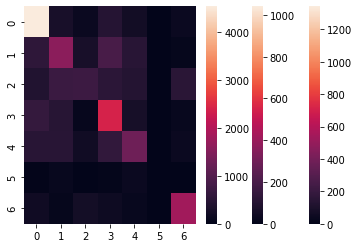



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.76      0.69      1774
           1       0.37      0.34      0.35      1247
           2       0.31      0.16      0.21      1024
           3       0.41      0.52      0.46      1233
           4       0.36      0.33      0.35       958
           5       0.00      0.00      0.00       111
           6       0.63      0.68      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.45      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1453
           1       0.34      0.35      0.35       970
           2       0.33      0.16      0.21       832
           3       0.41      0.50      0.45       987
           4       0.36      0.35      0.36       803
           5       0.00      0.00      0.00        94
           6       0.58      0.65      0.61       603

    accuracy                           0.47      5742
   macro avg       0.38      0.39      0.38      5742
weighted avg       0.45      0.47      0.45      5742

############# epoch 38 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.67      0.79      0.72      5762
           1       0.41      0.48      0.44      3860
           2       0.41      0.23      0.30      3265
           3       0.49      0.60      0.54      3978
           4       0.47      0.36      0.41      3192
           5       1.00      0.00      0.01       342
           6       0.68      0.68      0.68      2568

    accuracy                           0.54     22967
   macro avg       0.59      0.45      0.44     22967
weighted avg       0.54      0.54      0.52     22967



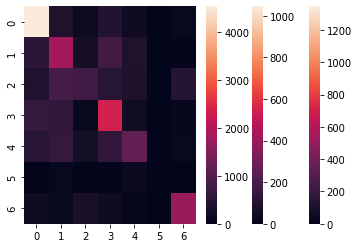



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.76      0.69      1774
           1       0.35      0.40      0.38      1247
           2       0.29      0.16      0.21      1024
           3       0.42      0.51      0.46      1233
           4       0.38      0.29      0.33       958
           5       1.00      0.01      0.02       111
           6       0.65      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.53      0.40      0.39      7178
weighted avg       0.47      0.48      0.46      7178



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1453
           1       0.33      0.41      0.36       970
           2       0.34      0.18      0.24       832
           3       0.41      0.48      0.45       987
           4       0.37      0.31      0.

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.70      0.77      0.73      5762
           1       0.40      0.52      0.45      3860
           2       0.41      0.24      0.30      3265
           3       0.50      0.57      0.54      3978
           4       0.46      0.37      0.41      3192
           5       1.00      0.00      0.01       342
           6       0.68      0.69      0.68      2568

    accuracy                           0.54     22967
   macro avg       0.59      0.45      0.45     22967
weighted avg       0.54      0.54      0.53     22967



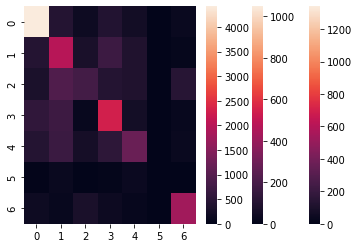



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.74      0.69      1774
           1       0.34      0.43      0.38      1247
           2       0.29      0.17      0.21      1024
           3       0.43      0.49      0.46      1233
           4       0.38      0.31      0.34       958
           5       0.00      0.00      0.00       111
           6       0.64      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.46      0.48      0.47      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.69      0.67      1453
           1       0.32      0.44      0.37       970
           2       0.34      0.19      0.24       832
           3       0.43      0.46      0.44       987
           4       0.37      0.33      0.35       803
           5       0.00      0.00      0.00        94
           6       0.60      0.64      0.62       603

    accuracy                           0.47      5742
   macro avg       0.39      0.39      0.38      5742
weighted avg       0.46      0.47      0.46      5742

############# epoch 40 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.81      0.72      5762
           1       0.42      0.44      0.43      3860
           2       0.45      0.20      0.28      3265
           3       0.49      0.58      0.53      3978
           4       0.44      0.41      0.42      3192
           5       0.00      0.00      0.00       342
           6       0.69      0.68      0.68      2568

    accuracy                           0.54     22967
   macro avg       0.45      0.44      0.44     22967
weighted avg       0.52      0.54      0.52     22967



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


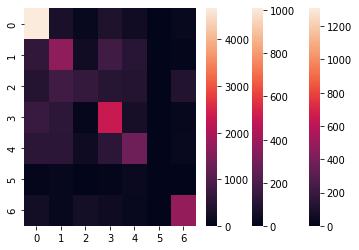



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.78      0.69      1774
           1       0.35      0.37      0.36      1247
           2       0.32      0.14      0.19      1024
           3       0.42      0.50      0.46      1233
           4       0.36      0.35      0.35       958
           5       0.00      0.00      0.00       111
           6       0.66      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.46      0.48      0.46      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.60      0.74      0.66      1453
           1       0.33      0.38      0.35       970
           2       0.34      0.14      0.20       832
           3       0.42      0.47      0.44       987
           4       0.36      0.36      0.36       803
           5       0.00      0.00      0.00        94
           6       0.60      0.61      0.61       603

    accuracy                           0.47      5742
   macro avg       0.38      0.38      0.37      5742
weighted avg       0.44      0.47      0.45      5742

############# epoch 41 ############


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.80      0.72      5762
           1       0.42      0.45      0.43      3860
           2       0.43      0.22      0.29      3265
           3       0.49      0.59      0.53      3978
           4       0.44      0.41      0.42      3192
           5       1.00      0.01      0.02       342
           6       0.70      0.68      0.69      2568

    accuracy                           0.54     22967
   macro avg       0.59      0.45      0.44     22967
weighted avg       0.54      0.54      0.52     22967



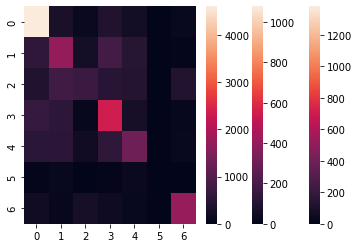



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.77      0.69      1774
           1       0.35      0.37      0.36      1247
           2       0.31      0.15      0.21      1024
           3       0.42      0.51      0.46      1233
           4       0.36      0.34      0.35       958
           5       1.00      0.01      0.02       111
           6       0.66      0.64      0.65       831

    accuracy                           0.48      7178
   macro avg       0.53      0.40      0.39      7178
weighted avg       0.47      0.48      0.46      7178



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.73      0.66      1453
           1       0.34      0.38      0.36       970
           2       0.34      0.16      0.22       832
           3       0.41      0.48      0.44       987
           4       0.36      0.35      0.

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.66      0.80      0.73      5762
           1       0.42      0.48      0.45      3860
           2       0.42      0.23      0.30      3265
           3       0.50      0.57      0.53      3978
           4       0.45      0.39      0.42      3192
           5       1.00      0.01      0.02       342
           6       0.71      0.66      0.68      2568

    accuracy                           0.54     22967
   macro avg       0.59      0.45      0.45     22967
weighted avg       0.54      0.54      0.53     22967



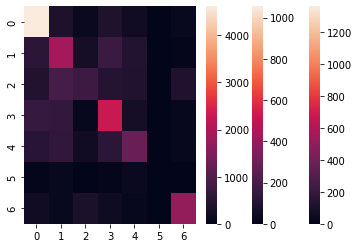



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.62      0.76      0.69      1774
           1       0.36      0.41      0.38      1247
           2       0.30      0.16      0.21      1024
           3       0.43      0.49      0.46      1233
           4       0.37      0.32      0.35       958
           5       1.00      0.01      0.02       111
           6       0.66      0.63      0.65       831

    accuracy                           0.48      7178
   macro avg       0.54      0.40      0.39      7178
weighted avg       0.48      0.48      0.47      7178



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.61      0.73      0.66      1453
           1       0.33      0.41      0.36       970
           2       0.34      0.17      0.23       832
           3       0.43      0.46      0.44       987
           4       0.37      0.35      0.

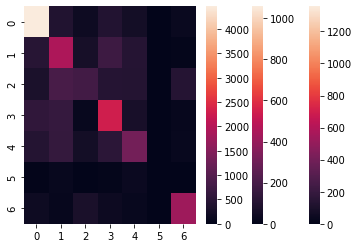



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.74      0.69      1774
           1       0.35      0.42      0.38      1247
           2       0.29      0.16      0.21      1024
           3       0.43      0.49      0.46      1233
           4       0.37      0.34      0.35       958
           5       0.00      0.00      0.00       111
           6       0.65      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.46      0.48      0.47      7178



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1453
           1       0.33      0.42      0.37       970
           2       0.33      0.17      0.23       832
           3       0.42      0.46      0.44       987
           4       0.36      0.36      0.36       803
           5       1.00      0.01      0.02        94
           6       0.61      0.63      0.62       603

    accuracy                           0.47      5742
   macro avg       0.53      0.39      0.39      5742
weighted avg       0.47      0.47      0.45      5742

############# epoch 44 ############


########## Train Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.69      0.78      0.73      5762
           1       0.41      0.50      0.45      3860
           2       0.41      0.24      0.30      3265
           3       0.50      0.59      0.54      3978
    

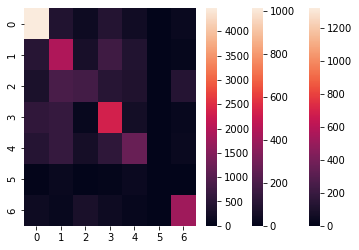



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.74      0.69      1774
           1       0.35      0.42      0.38      1247
           2       0.30      0.17      0.21      1024
           3       0.42      0.50      0.46      1233
           4       0.38      0.31      0.34       958
           5       1.00      0.01      0.02       111
           6       0.64      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.53      0.40      0.39      7178
weighted avg       0.48      0.48      0.47      7178



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.71      0.67      1453
           1       0.33      0.43      0.37       970
           2       0.34      0.18      0.24       832
           3       0.42      0.47      0.44       987
           4       0.37      0.33      0.

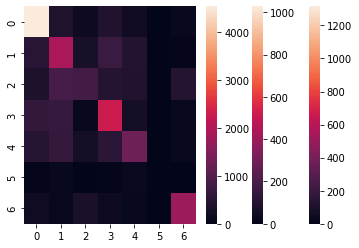



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1774
           1       0.35      0.42      0.38      1247
           2       0.29      0.16      0.21      1024
           3       0.43      0.49      0.46      1233
           4       0.37      0.32      0.34       958
           5       1.00      0.01      0.02       111
           6       0.65      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.53      0.40      0.39      7178
weighted avg       0.48      0.48      0.47      7178



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1453
           1       0.33      0.42      0.37       970
           2       0.34      0.18      0.24       832
           3       0.43      0.45      0.44       987
           4       0.36      0.34      0.

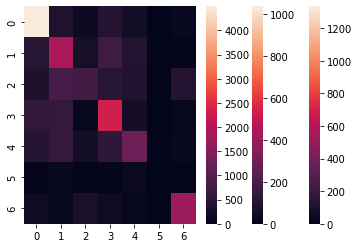



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1774
           1       0.36      0.41      0.38      1247
           2       0.30      0.16      0.21      1024
           3       0.42      0.50      0.46      1233
           4       0.37      0.32      0.35       958
           5       1.00      0.01      0.02       111
           6       0.65      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.54      0.40      0.39      7178
weighted avg       0.48      0.48      0.47      7178



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.71      0.67      1453
           1       0.33      0.42      0.37       970
           2       0.34      0.18      0.23       832
           3       0.42      0.47      0.44       987
           4       0.37      0.34      0.

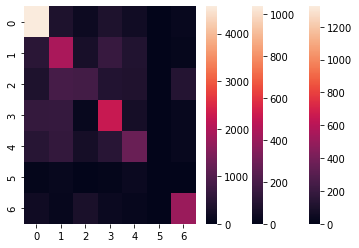



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.76      0.69      1774
           1       0.35      0.42      0.38      1247
           2       0.29      0.17      0.22      1024
           3       0.44      0.48      0.46      1233
           4       0.38      0.32      0.34       958
           5       1.00      0.01      0.02       111
           6       0.65      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.53      0.40      0.39      7178
weighted avg       0.48      0.48      0.47      7178



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1453
           1       0.33      0.43      0.37       970
           2       0.34      0.19      0.24       832
           3       0.43      0.44      0.44       987
           4       0.37      0.34      0.

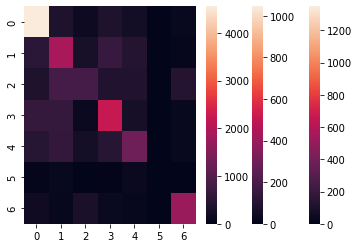



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.76      0.69      1774
           1       0.35      0.41      0.38      1247
           2       0.29      0.17      0.22      1024
           3       0.44      0.47      0.46      1233
           4       0.36      0.32      0.34       958
           5       1.00      0.01      0.02       111
           6       0.65      0.65      0.65       831

    accuracy                           0.48      7178
   macro avg       0.53      0.40      0.39      7178
weighted avg       0.47      0.48      0.47      7178



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1453
           1       0.33      0.42      0.37       970
           2       0.34      0.19      0.24       832
           3       0.43      0.43      0.43       987
           4       0.37      0.35      0.

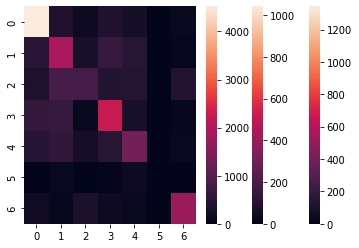



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1774
           1       0.35      0.41      0.38      1247
           2       0.30      0.17      0.22      1024
           3       0.44      0.47      0.46      1233
           4       0.36      0.34      0.35       958
           5       1.00      0.01      0.02       111
           6       0.65      0.64      0.65       831

    accuracy                           0.48      7178
   macro avg       0.53      0.40      0.39      7178
weighted avg       0.48      0.48      0.47      7178



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1453
           1       0.33      0.42      0.37       970
           2       0.34      0.19      0.24       832
           3       0.43      0.44      0.44       987
           4       0.36      0.36      0.

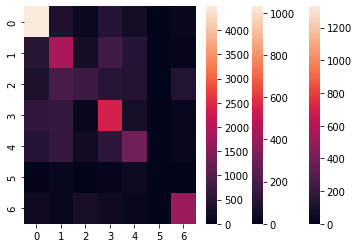



########## Test Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.65      0.74      0.69      1774
           1       0.36      0.41      0.38      1247
           2       0.31      0.15      0.21      1024
           3       0.42      0.51      0.46      1233
           4       0.37      0.34      0.35       958
           5       1.00      0.01      0.02       111
           6       0.66      0.64      0.65       831

    accuracy                           0.48      7178
   macro avg       0.54      0.40      0.39      7178
weighted avg       0.48      0.48      0.47      7178



########## Valid Data Accuracy ######### 


              precision    recall  f1-score   support

           0       0.64      0.71      0.67      1453
           1       0.34      0.42      0.37       970
           2       0.34      0.16      0.22       832
           3       0.41      0.47      0.44       987
           4       0.37      0.36      0.

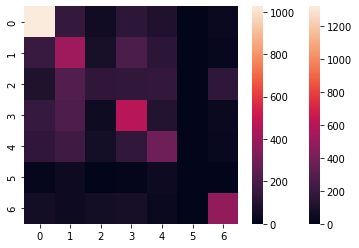

In [19]:
test_acc,train_acc,valid_acc= [],[],[]
for epoch in range(epochs):
    print("############# epoch {} ############".format(epoch+1))
    
    train_acc_score, test_acc_score,valid_acc_score = accuracy(train_loader,test_loader,valid_loader,models[epoch]['model'],reshape=False)
    train_acc.append(train_acc_score)
    test_acc.append(test_acc_score)
    valid_acc.append(valid_acc_score)


    

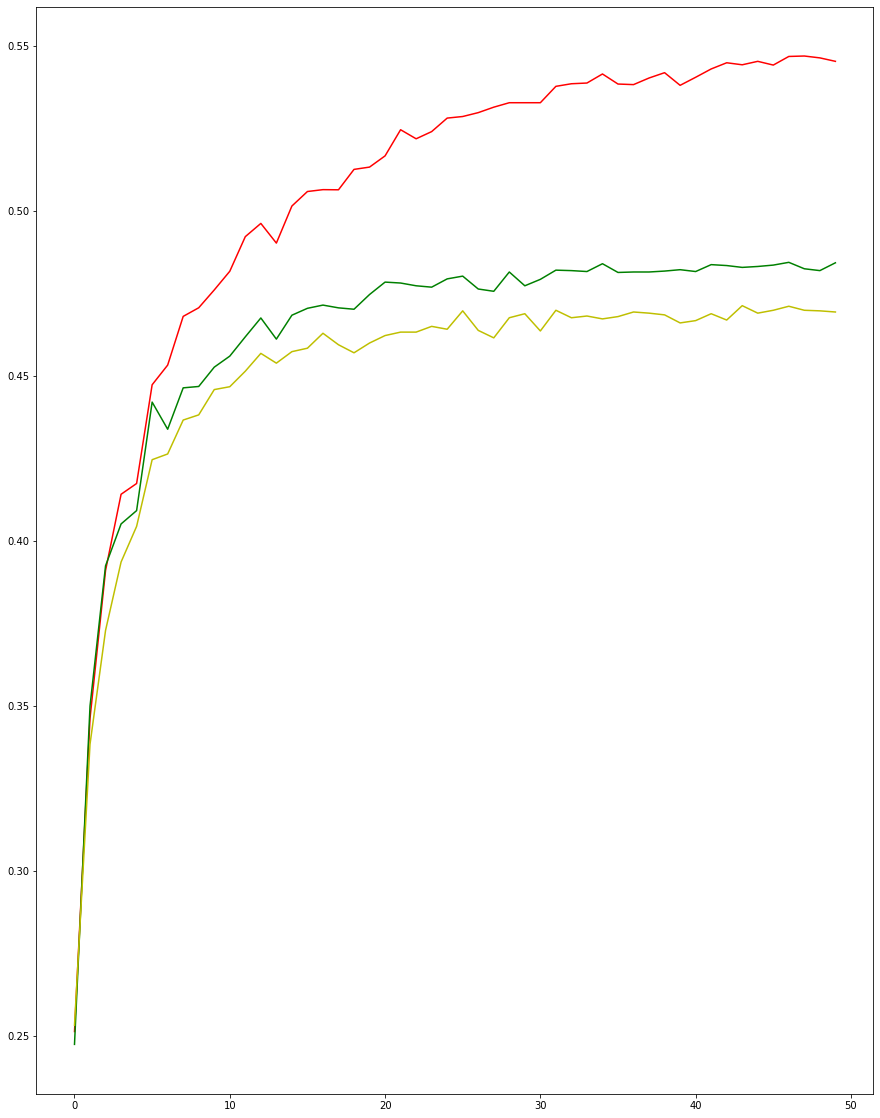

In [20]:
fig = plt.figure(figsize=(15,20))
plt.plot(range(epochs),train_acc,'-r')
plt.plot(range(epochs),test_acc,'-g')
plt.plot(range(epochs),valid_acc,'-y')

In [21]:
for epoch in range(epochs):
    print(f'Epoch: {epoch}\n \
    Validation Accracy: {valid_acc[epoch]}\n \
    test Accracy: {test_acc[epoch]}\n \
    train Accracy: {train_acc[epoch]}')

Epoch: 0
     Validation Accracy: 0.25322187391152906
     test Accracy: 0.24742268041237114
     train Accracy: 0.25131710715374234
Epoch: 1
     Validation Accracy: 0.3383838383838384
     test Accracy: 0.3499582056283087
     train Accracy: 0.3462359036879
Epoch: 2
     Validation Accracy: 0.37286659700452807
     test Accracy: 0.39244915018110893
     train Accracy: 0.3910393172813167
Epoch: 3
     Validation Accracy: 0.39359108324625564
     test Accracy: 0.4051267762607969
     train Accracy: 0.4141159054295293
Epoch: 4
     Validation Accracy: 0.4043887147335423
     test Accracy: 0.40916689885762053
     train Accracy: 0.4173814603561632
Epoch: 5
     Validation Accracy: 0.42459073493556254
     test Accracy: 0.4420451379214266
     train Accracy: 0.44729394348412943
Epoch: 6
     Validation Accracy: 0.4263322884012539
     test Accracy: 0.43382557815547507
     train Accracy: 0.45325902381678057
Epoch: 7
     Validation Accracy: 0.43660745384883315
     test Accracy: 0.4463638